# Recommender system project:
Code based on a tutorial by Agnes Johannsdottir using MovieLens data set.  
Here I use the million song data set from Kaggle.

See bottom for SVD.




# P1: Item Similarity

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [75]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn import cross_validation as cv
import random

In [6]:
def countNonZeroEntries(matrix):
    m = np.zeros(matrix.shape[0])
    for x in range(0, matrix.shape[0]):
        m[x] = len(matrix[x][matrix[x]!=0])
    return m

In [7]:
def normalizeRowsToOne(matrix):
    m = np.zeros(matrix.shape[0])
    for x in range(0, matrix.shape[0]):
        m[x] = len(matrix[x][matrix[x]!=0])
    return m

In [8]:
def replaceNANwithZero(matrix):
    m = np.zeros((matrix.shape[0], matrix.shape[1]))
    for x in range(0, matrix.shape[0]):
        matrix[x] = np.nan_to_num(matrix[x])
    return m
    

In [9]:
def normalize1(similarity):
    '''sum similarities for each row'''
    n = np.array([np.abs(similarity).sum(axis=1)]) 
    for x in range(0, len(n[0])):
        if n[0][x] < 1:
            n[0][x] = 1         
    return n

In [10]:
def normalize(pred, countratingsperrow):
    '''by count of non-zero ratings per row'''
    for row in range(0, pred.shape[0]):
        for col in range(0, pred.shape[1]):
            if pred[row,col] != 0:
                pred[row,col] = pred[row,col]/countratingsperrow[row]
    return pred

In [11]:
def normalize2(pred, normMatrix):
    '''by norm sim value to 1; only using cases where dot product is non-zero'''
    for row in range(0, pred.shape[0]):
        for col in range(0, pred.shape[1]):
            if pred[row,col] != 0:
                pred[row,col] = pred[row,col]*normMatrix[row,col]
    return pred

In [12]:
def getNormMatrix(similarity, ratings):
    l1 = np.zeros((ratings.shape[0], ratings.shape[1]))
    for c in range (0, similarity.shape[0]):
        for r in range (0, ratings.shape[0]):
            new = similarity[c]*ratings[r]
            i = np.nonzero(new)
            nzero = np.sum(similarity[c][i])
            if nzero == 0:
                normfactor = 1
            else:
                normfactor = 1.0/nzero
            l1[r,c] = normfactor
    return l1
        

In [13]:
def convertToMinOne(m):
    for r in range(0, m.shape[0]):
        for c in range(0,m.shape[1]):
            if m[r][c] < 1:
                m[r][c] = 1
    return m
              

In [14]:
def transferKnownvalues(p,test):
    for r in range(0, test.shape[0]):
        for c in range(0,test.shape[1]):
            if test[r][c] != 0:
                p[r][c] = test[r][c]
    return p
    

Below are 4 different prediction methods, each with a different way to normalize.

In [15]:
#predict(train_data_matrix, user_similarity, type='user')
def predict(ratings, similarity, type='user'):
    '''orginal predict fuction, normalize by summing all similiarity numbers'''
    if type == 'user':
        pass
    elif type == 'item':
        pred = ratings.dot(similarity) / normalize1(similarity)    
    return pred

In [16]:
def predict2(ratings, similarity, type='user'):
    '''No normalization'''
    if type == 'user':
        pass
    elif type == 'item':
        countratingsperrow = countNonZeroEntries(ratings)
        pred = ratings.dot(similarity)  
    return pred

In [17]:
def predict3(ratings, similarity, type='user'):
    '''normalized, by count of nonzero ratings'''
    if type == 'user':
        pass
    elif type == 'item':
        countratingsperrow = countNonZeroEntries(ratings)
        pred = ratings.dot(similarity)  
        pred = normalize(pred, countratingsperrow)
    return pred

In [18]:
def predict4(ratings, similarity, type='user'):
    '''normalized by sum of similarity values associated with non-zero ratings and normalize to 1'''
    if type == 'user':
        pass
    elif type == 'item':
        pred = ratings.dot(similarity) 
        normMatrix = getNormMatrix(similarity, ratings)
        pred = normalize2(pred, normMatrix)
    return pred

In [19]:
def rmse(p, test):
    '''this determines the rmse for the predicted values versus the test values.  It only considers 
    real ratings in the text matrix and ignores -non-ratings- ie zeros'''
    errors = []
    for r in range(0, test.shape[0]):
        for c in range(0,test.shape[1]):
            if test[r][c] != 0:
                errors.append(float(test[r,c])-float(p[r,c]))
    errors1 =  np.asarray(errors)
    errors2 = np.mean(errors1*errors1)
    return sqrt(errors2)

Below I read in the data

In [20]:
data = []
with open("/Users/alexandersatz/Documents/Cuny/IS643_recommenderSys/project1/kaggle_visible_evaluation_triplets.txt", "r") as f:
    for line in f:
        line = line[:-1]
        line =line.split('\t')
        data.append(line)

In [21]:
de_item = defaultdict(int)
for row in data:
    de_item[row[1]] += 1
    

In [22]:
#Here I'm removing items with few reviews.
d_itemGTE5 = {}
for key, value in de_item.iteritems():
    if value > 50:
        d_itemGTE5[key] = 1

In [23]:
print len(d_itemGTE5)
print len(de_item)

4677
163206


In [24]:
shortdata = []
for x in data:
    if x[1] in d_itemGTE5:
        shortdata.append(x)

In [25]:
de_user = defaultdict(int)
for row in shortdata:
    de_user[row[0]] += 1
    

In [26]:
#Here I'm removing users with few reviews.
d_usersGTE10 = {}
for key, value in de_user.iteritems():
    if value > 20:
        d_usersGTE10[key] = 1

In [27]:
shortdata2 = []
for x in shortdata:
    if x[0] in d_usersGTE10:
        shortdata2.append(x)

In [28]:
shortdata = shortdata2

In [29]:
## So I've gone from 1.45 million rows of data to ~42,0000
print(len(data))
print(len(shortdata))

1450933
42443


In [30]:
#data from https://www.kaggle.com/c/msdchallenge/data
#the number of times a user listens to a song is tracked

#here 'rating' is number of listens to the song.
header = ['user_id', 'item_id', 'rating']
df = pd.DataFrame(shortdata, columns=header)

In [31]:
# max listen is now 10, which represents 'liking' a song
for index, row in df.iterrows():
    if int(row['rating']) > 10:
        row['rating'] = 10

In [32]:
#I need to convert each user_id to an int, and each item_id to an int.
arrayusers = df.user_id.unique()
arrayitems = df.item_id.unique()
d_users, d_items = {}, {}
c = 0
for x in arrayusers:
    c +=1
    d_users[x] = c 
c = 0
for x in arrayitems:
    c +=1
    d_items[x] = c 


In [33]:
for index, row in df.iterrows():
    df.set_value(index, 'user_id', d_users[row['user_id']])
    df.set_value(index, 'item_id', d_items[row['item_id']])

In [34]:
df.head(5)

,user_id,item_id,rating
0,1,1,5
1,1,2,1
2,1,3,1
3,1,4,1
4,1,5,1


In [35]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print 'Number of users = ' + str(n_users) + ' | Number of items = ' + str(n_items)  

Number of users = 1750 | Number of items = 4349


Note that the above data split needs to give equal numbers of users in the train and test set!  Sometimes this doesn't happen and the above split needs to be repeated until it does.

In [76]:
b = True
count = 0

while b and count <100:
    train_data, test_data = cv.train_test_split(df, test_size=0.26)
    random.seed(count)
    count += 1
    #Create two user-item matrices, one for training and another for testing
    ## row number = user_id-1, column number is item_id-1, and value is the rating.
    ## so each row has all ratings for every movie for that user (else a zero)
    try:
        n_users = train_data.user_id.unique().shape[0]
        train_data_matrix = np.zeros((n_users, n_items))
        for line in train_data.itertuples():
            train_data_matrix[line[1]-1, line[2]-1] = line[3]  



        n_users = test_data.user_id.unique().shape[0]
        test_data_matrix = np.zeros((n_users, n_items))
        for line in test_data.itertuples():
            test_data_matrix[line[1]-1, line[2]-1] = line[3]
        b = False
    except IndexError:
        b = True
    
print n_users
    
print n_users  ## make sure both matrices have same # users

1750
1750


In [77]:
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [78]:
## make simliarity matrix have diagonal of 1's not zeros
for row in range(0, (item_similarity.shape[0])):
    for col in range(0, (item_similarity.shape[1])):
        item_similarity[row,col] = 1-item_similarity[row,col]

In [66]:
item_prediction1 = predict(test_data_matrix, item_similarity, type='item')
item_prediction2 = predict2(test_data_matrix, item_similarity, type='item')
item_prediction3 = predict3(test_data_matrix, item_similarity, type='item')
item_prediction4 = predict4(test_data_matrix, item_similarity, type='item')

In [43]:
#Normalize sum of similarities for each row
print 'Item-based CF RMSE: ' + str(rmse(item_prediction1, test_data_matrix))
#No normalization
print 'Item-based CF RMSE: ' + str(rmse(item_prediction2, test_data_matrix))
#Count of actual ratings in a column, train_data_matrix
print 'Item-based CF RMSE: ' + str(rmse(item_prediction3, test_data_matrix))
#Normalize by summing the similarities and normalizing to 1, but only for those corresponding to a rating 
#in the train_data_matrix (rows are items, columns are users)
print 'Item-based CF RMSE: ' + str(rmse(item_prediction4, test_data_matrix))

Item-based CF RMSE: 3.71953908924
Item-based CF RMSE: 1.01252148931
Item-based CF RMSE: 3.34999622936
Item-based CF RMSE: 0.694641986948


In [44]:
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print 'The sparsity level is ' +  str(sparsity*100) + '%'

The sparsity level is 99.4%


Below we look at the RMSE if we just assumed the 'average' rating for each item

In [45]:
## for we determine the average of all ratings in the matrix, ignoring zeros since we consider them to be 'non-ratings'
s = np.sum(test_data_matrix)
c = len(np.nonzero(test_data_matrix)[0])
m = s/float(c)
## the average rating in the matrix
print m

2.88501268576


In [46]:
#create a matrix of the average
matrix_avg = np.zeros((test_data_matrix.shape[0], test_data_matrix.shape[1]))
for row in range(0, matrix_avg.shape[0]):
        for col in range(0, matrix_avg.shape[1]):
            matrix_avg[row][col] = m
print 'Item-based CF RMSE: ' + str(rmse(matrix_avg, test_data_matrix))
## the RMSE if all predictions were the average in the matrix

Item-based CF RMSE: 2.79515517491


In [47]:
i = np.nonzero(test_data_matrix)
t = test_data_matrix[i].flatten()
p = item_prediction4[i].flatten()


The Plot below shows that the predicted values track well with the 'test' values.  There might be a bit of an issue with some data points showing up at the baseline though; I think this may be due to matrix sparsity, cases when there is no overlap between ratings and similarity values.

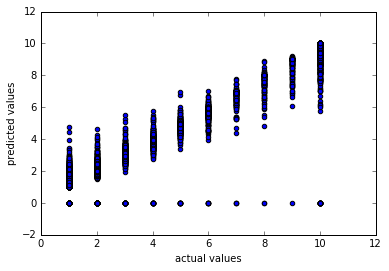

In [49]:
plt.scatter(t, p)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

# P2:  Below I try to set up on a normalized User-based CF.

In [79]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

In [80]:
## make simliarity matrix have diagonal of 1's not zeros
for row in range(0, (user_similarity.shape[0])):
    for col in range(0, (user_similarity.shape[1])):
        user_similarity[row,col] = 1-user_similarity[row,col]

In [101]:
#predict(train_data_matrix, user_similarity, type='user')
def predict_UB1(ratings, similarity, type='user'):
    '''orginal predict fuction for the UB CF as taken from the online source.  As you can see, it takes a mean user
    rating, but does not exclude zero in the average.  And it normalizes with the sum of similarities. '''
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)  # array with mean for each user
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / normalize1(similarity).T
    elif type == 'item':
        pass   
    return pred

In [82]:
def getMeanUserRating(ratings):
    l1 = []
    for x in range(0, ratings.shape[0]):
        l1.append(np.mean(ratings[x][np.nonzero(ratings[x])]))
    return np.asarray(l1)
        

In [83]:
def getNormMatrixUB(similarity, ratings):
    l1 = np.zeros((ratings.shape[0], ratings.shape[1]))
    for c in range (0, ratings.shape[0]):
        for r in range (0, similarity.shape[0]):
            new = ratings[:,c]*similarity[r]
            i = np.nonzero(new)
            nzero = np.sum(similarity[c][i])
            if nzero == 0:
                normfactor = 1
            else:
                normfactor = 1.0/nzero
            l1[r,c] = normfactor
    return l1
        

In [84]:
user_prediction1 = predict_UB1(test_data_matrix, user_similarity, type='user')

As you can see, this user based collaborative filtering still needs some help.  Mainly I think it does the normalization incorrectly, and needs a better method for dealing with some users ranking all high or low.

In [85]:
print 'User-based CF RMSE: ' + str(rmse(user_prediction1, test_data_matrix))

User-based CF RMSE: 3.73947934863


# Below I try SVD with varying types of imputation.  All in all, SVD is not particularly beneficial.  Intuitively, a content based filter might be better suited to dimension reduction.

The MSE is pretty bad (see below).  I think this is because of a lack of imputing values, which for this svd case may be important.  What's interesting about this technique, is if you use a very large value of k, then all the predicted values would be zero (hence the need to impute...).

In [103]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 10)  # k is deciding the number of latent variables to take.  
s_diag_matrix=np.diag(s)  # generates the diagonal matrix; s above is a 1-D array.
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)  #because k =10, X_pred != train_data_matrix
print 'User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))

User-based CF MSE: 3.87210901377


### So, below I impute with the mean of the entire training set.  The result is much better, with a MSE now of 2.8.  Of course, there might be better ways to impute.  

In [104]:
def getMean(m):
    s = np.sum(m)
    c = len(np.nonzero(m)[0])
    a = s/float(c)
    return a
    

In [105]:
def imputeWithMean(m, mean):
    m2 = np.zeros((m.shape[0], m.shape[1]))
    for r in range(0, m.shape[0]):
        for c in range(0,m.shape[1]):
            m2[r][c] = m[r][c]
            if m[r][c] == 0:
                m2[r][c] = mean
    return m2
                
    

In [106]:
mean = getMean(train_data_matrix)

In [107]:
imputed_train = imputeWithMean(train_data_matrix, mean)

In [108]:
u, s, vt = svds(imputed_train, k = 10)  # k is deciding the number of latent variables to take.  
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)  #because k =10, X_pred != train_data_matrix
print 'User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))

User-based CF MSE: 2.7107006987


### Below I impute with the average rating of each item (and not just with the average of the whole matrix).  The avg item imputing seems to do a really bad job.  This makes some sense if you assume that songs are largely one of personal taste (ie there is no such thing as a highly rated song across all users).

In [125]:
# find average for each item
def fAvgEachItem(m):
    l1 = []
    t = np.transpose(m)
    for r in range(0, t.shape[0]):
        i = np.nonzero(t[r])
        v = np.mean(t[r][i])
        if v == 0:
            v = 1
        l1.append(v)
    return l1
    

In [127]:
def imputeItemAvg(m, meanslist):
    m2 = np.zeros((m.shape[0], m.shape[1]))
    for r in range(0, m.shape[0]):
        for c in range(0,m.shape[1]):
            m2[r][c] = m[r][c]
            if m[r][c] == 0:
                m2[r][c] = meanslist[c]
    return m2
    

In [128]:
meanslist = fAvgEachItem(train_data_matrix)

In [129]:
imputed_train2 = imputeItemAvg(train_data_matrix, meanslist)

In [130]:
u, s, vt = svds(imputed_train2, k = 10)  # k is deciding the number of latent variables to take.  
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)  #because k =10, X_pred != train_data_matrix
print 'User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))

User-based CF MSE: 3.95268087735


### Below I instead impute with the user avg rating and am able to see an improvment over the global avg by the MSE dropping from 2.8 to 2.4.  Also, increasing the number of latent variables from 10 to 20 did not improve matters.  I think its very telling that setting the number of latent variable to 1 still gives a MSE of 2.4.

In [145]:
# find average for each item
def fAvgEachUser(m):
    l1 = []
    for r in range(0, m.shape[0]):
        i = np.nonzero(m[r])
        v = np.mean(m[r][i])
        if v == 0:
            v = 1
        l1.append(v)
    return l1
    

In [146]:
def imputeUsrAvg(m, meanslist):
    m2 = np.zeros((m.shape[0], m.shape[1]))
    for r in range(0, m.shape[0]):
        for c in range(0,m.shape[1]):
            m2[r][c] = m[r][c]
            if m[r][c] == 0:
                m2[r][c] = meanslist[r]
    return m2

In [147]:
meanslist = fAvgEachUser(train_data_matrix)
imputed_train3 = imputeUsrAvg(train_data_matrix, meanslist)

In [149]:
u, s, vt = svds(imputed_train3, k = 10)  # k is deciding the number of latent variables to take.  
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)  #because k =10, X_pred != train_data_matrix
print 'User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))

User-based CF MSE: 2.43327475325


In [160]:
u, s, vt = svds(imputed_train3, k = 20)  # k is deciding the number of latent variables to take.  
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)  #because k =10, X_pred != train_data_matrix
print 'User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))

User-based CF MSE: 2.43509374162


In [158]:
u, s, vt = svds(X_pred, k = 1)  # k is deciding the number of latent variables to take.  
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)  #because k =10, X_pred != train_data_matrix
print 'User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))

User-based CF MSE: 2.43808793925


## As the SVD doesn't provide very good results, I thought I'd try alternating least squares.

The link to the blog which covered this is below.  It was a very good blog on the topic, I thought, and easy to use with my exisiting data set.

The key to ALS is that its basically an imputation method.  You can impute with the median or avg, but you can also impute by OLS using the existing values.  For imputation this is considered more advanced, but also more complex (and bad) in many cases.  For our situation here, perhaps its better.  Basically, the imputed values ARE the answers you're looking for.

https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/

In [161]:
W = train_data_matrix>0.5
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

In [179]:
Q = train_data_matrix
lambda_ = 0.1
n_factors = 100
m, n = Q.shape
n_iterations = 15

In [165]:
X = 5 * np.random.rand(m, n_factors) 
Y = 5 * np.random.rand(n_factors, n)

In [166]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

In [167]:
errors = []
for ii in range(n_iterations):
    X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(n_factors), 
                        np.dot(Y, Q.T)).T
    Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(n_factors),
                        np.dot(X.T, Q))
    if ii % 100 == 0:
        print('{}th iteration is completed'.format(ii))
    errors.append(get_error(Q, X, Y, W))
Q_hat = np.dot(X, Y)
print('Error of rated movies: {}'.format(get_error(Q, X, Y, W)))

0th iteration is completed
Error of rated movies: 230178.194643


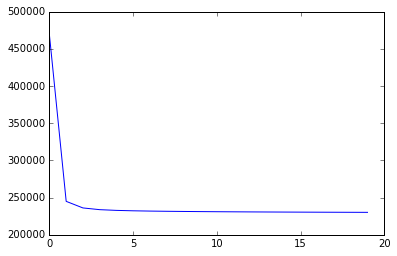

In [178]:
# as you can see, after the 5th iteration, nothing gets better.  This is your run of the mill imputing as I did above; 
# similiar to imputing a user average.
plt.plot(errors);

In [180]:
weighted_errors = []
for ii in range(n_iterations):
    for u, Wu in enumerate(W):
        X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
                               np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    for i, Wi in enumerate(W.T):
        Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
    weighted_errors.append(get_error(Q, X, Y, W))
    print('{}th iteration is completed'.format(ii))
weighted_Q_hat = np.dot(X,Y)
#print('Error of rated movies: {}'.format(get_error(Q, X, Y, W)))

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed


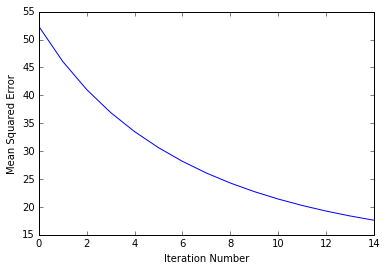

In [181]:
#below is the iterative imputing based on OLS, with each iteration the MSE gets better.
plt.plot(weighted_errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');

In [2]:
# the RMSE is ~ 3.7.
14**.5

3.7416573867739413

# P4: Below I try to optimze the normalized User-based CF.

above in Part 2, I set up at User based CF, and it had a **RMSE of 3.7**, which is quite bad.  Note that the SVD and alternating least squares techniques were little better.


The function I used in P2 is below.  In it I take a ratings matrix of 1750 users (rows) and 4349 songs (columns), and a similiarty matrix of users which is 1750x1750:

#predict(train_data_matrix, user_similarity, type='user')
def predict_UB1(ratings, similarity, type='user'):
    '''orginal predict fuction for the UB CF as taken from the online source.  As you can see, it takes a mean user
    rating, but does not exclude zero in the average.  And it normalizes with the sum of similarities. '''
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)  # array with mean for each user
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / normalize1(similarity).T
    elif type == 'item':
        pass   
    return pred
    
### in the end.  I've generated a method for normalizing which gives a RMSE of 1.0.  This normalization, takes into account the sparsity of the matrix.  Further, I've developed a method for accounting for user bias, such that user ratings are normalized prior to prediction, and then 'non-normalized' again; this method gives a RMSE of 0.8 !!

A draw back of this technique, is that it is computationally expensive and slow as dirt.

I generate a mean user rating, which is the average of each row (user) in the ratings matrix.  Note that this average includes zeros!  So this is one issue.  I would rather get the average of the nonzero values.  I starting looking into this in P2, but wasn't able to finish.  Below, I have a working function for getting the average rating (not including zeros) for each user.

In [90]:
def getMeanUserRating(ratings):
    l1 = []
    for x in range(0, ratings.shape[0]):
        l1.append(np.mean(ratings[x][np.nonzero(ratings[x])]))
    return np.asarray(l1)

0.0096573925040239136

In [102]:
def predict_UB2(ratings, similarity, type='user'):
    '''this has a mean user rating that exludes zeros.  It normalizes by summing the similiarities for each user. '''
    if type == 'user':
        mean_user_rating = getMeanUserRating(ratings)  # array with mean for each user
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / normalize1(similarity).T
    elif type == 'item':
        pass   
    return pred

In [105]:
user_prediction1 = predict_UB2(test_data_matrix, user_similarity, type='user')

In [106]:
print 'User-based CF RMSE: ' + str(rmse(user_prediction1, test_data_matrix))

User-based CF RMSE: 3.34404139736


The above RMSE is a bit better.  Still the function is doing somethign a bit odd with the 'ratings_diff' variable in that ratings that are 'zero' are being adjusted, even though these aren't really ratings at all.

In [133]:
def normalizeForUserRatings (ratings, mean_user_rating):
    globalAvg = np.mean(mean_user_rating)
    return ratings*(globalAvg/mean_user_rating)[:,np.newaxis]        

In [146]:
def predict_UB3(ratings, similarity, type='user'):
    '''Normalizes user ratings.  It normalizes by summing the similiarities for each user.  '''
    if type == 'user':
        mean_user_rating = getMeanUserRating(ratings)  # array with mean for each user
        ratings_norm = normalizeForUserRatings (ratings, mean_user_rating) 
        pred = similarity.dot(ratings_norm) / normalize1(similarity).T
    elif type == 'item':
        pass   
    return pred

In [147]:
user_prediction3 = predict_UB3(test_data_matrix, user_similarity, type='user')
print 'User-based CF RMSE: ' + str(rmse(user_prediction3, test_data_matrix))

User-based CF RMSE: 3.78615352986


The problem with the above, is it normalizes the users ratings, but then it doesn't 'add back in' the difference.  However, as shown below, adding the differing back in does not help much...

In [140]:
def DenormalizeForUserRatings (pred, mean_user_rating):
    globalAvg = np.mean(mean_user_rating)
    return pred*(mean_user_rating/globalAvg)[:,np.newaxis]   

In [189]:
def predict_UB4(ratings, similarity, type='user'):
    '''Normalizes user ratings, and then adds the values back in.  It normalizes by summing the similiarities for each user. '''
    if type == 'user':
        mean_user_rating = getMeanUserRating(ratings)  # array with mean for each user
        ratings_norm = normalizeForUserRatings (ratings, mean_user_rating) 
        pred = similarity.dot(ratings_norm) / normalize1(similarity).T
    elif type == 'item':
        pass   
    return DenormalizeForUserRatings(pred, mean_user_rating)

In [190]:
user_prediction4 = predict_UB4(test_data_matrix, user_similarity, type='user')
print 'User-based CF RMSE: ' + str(rmse(user_prediction4, test_data_matrix))

User-based CF RMSE: 3.72838477679


I'm not seeing much improvment.  As a test I try without any normalizing...which looks very bad..and then with normalizing but not accounting for user tendencies, which give ~3.8 again.  Note that for content based, no normalizing gave a good result with a RMSE of just ~1-2.

In [195]:
def predict_UB5(ratings, similarity, type='user'):
    '''no normalization for ratings '''
    if type == 'user':
        mean_user_rating = getMeanUserRating(ratings)  # array with mean for each user
        ratings_norm = normalizeForUserRatings (ratings, mean_user_rating) 
        pred = similarity.dot(ratings_norm)
    elif type == 'item':
        pass   
    return pred

In [196]:
user_prediction5 = predict_UB5(test_data_matrix, user_similarity, type='user')
print 'User-based CF RMSE: ' + str(rmse(user_prediction5, test_data_matrix))

User-based CF RMSE: 5.52816867245


In [193]:
def predict_UB6(ratings, similarity, type='user'):
    '''another version of no normalization'''
    if type == 'user':
        pred = similarity.dot(ratings) 
    elif type == 'item':
        pass   
    return pred

In [194]:
user_prediction6 = predict_UB6(test_data_matrix, user_similarity, type='user')
print 'User-based CF RMSE: ' + str(rmse(user_prediction6, test_data_matrix))

User-based CF RMSE: 5.03722862297


I'm not making much progess in reducing the RMSE.  Lets take a look at the normalization functions. The first two I used for the item based CF filters.  The last function didn't work, so I try to fix as shown in the next cell.

def normalize1(similarity):
    '''sum similarities for each row'''
    n = np.array([np.abs(similarity).sum(axis=1)]) 
    for x in range(0, len(n[0])):
        if n[0][x] < 1:
            n[0][x] = 1         
    return n
    
    
def getNormMatrix(similarity, ratings):
    l1 = np.zeros((ratings.shape[0], ratings.shape[1]))
    for c in range (0, similarity.shape[0]):
        for r in range (0, ratings.shape[0]):
            new = similarity[c]*ratings[r]
            i = np.nonzero(new)
            nzero = np.sum(similarity[c][i])
            if nzero == 0:
                normfactor = 1
            else:
                normfactor = 1.0/nzero
            l1[r,c] = normfactor
    return l1
    
    
def getNormMatrixUB(similarity, ratings):
    l1 = np.zeros((ratings.shape[0], ratings.shape[1]))
    for c in range (0, ratings.shape[0]):
        for r in range (0, similarity.shape[0]):
            new = ratings[c]*similarity[r]
            i = np.nonzero(new)
            nzero = np.sum(similarity[c][i])
            if nzero == 0:
                normfactor = 1
            else:
                normfactor = 1.0/nzero
            l1[r,c] = normfactor
    return l1
    
       
        

In [201]:
def getNormMatrixUB2(similarity, ratings):
    l1 = np.zeros((ratings.shape[0], ratings.shape[1]))
    for r in range (0, ratings.shape[0]):
        for c in range (0, ratings.shape[1]):
            new = similarity[r]*ratings[:,c]
            i = np.nonzero(new)
            nzero = np.sum(similarity[r][i])
            if nzero == 0:
                normfactor = 1
            else:
                normfactor = 1.0/nzero
            l1[r,c] = normfactor
    return l1

In [204]:

def predict_UB7(ratings, similarity, type='user'):
    '''orginal predict fuction for the UB CF as taken from the online source.  As you can see, it takes a mean user
    rating, but does not exclude zero in the average.  And it normalizes with the sum of similarities. '''
    if type == 'user':
        pred = similarity.dot(ratings)
        normMatrix = getNormMatrixUB2(similarity, ratings)
        pred = normalize2(pred, normMatrix)
    elif type == 'item':
        pass   
    return DenormalizeForUserRatings(pred, mean_user_rating)        


Finally!  Some real progress.  I still need to clean up the function, and decide if I'm also normalizing for user ratings.

In [205]:
user_prediction7 = predict_UB7(test_data_matrix, user_similarity, type='user')
print 'User-based CF RMSE: ' + str(rmse(user_prediction7, test_data_matrix))

User-based CF RMSE: 2.52741278562


In [113]:
mean_user_rating = getMeanUserRating(test_data_matrix)  # array with mean for each user
ratings_diff = (test_data_matrix - mean_user_rating[:, np.newaxis]) 
pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / normalize1(user_similarity).T

Below I normalize for user ratings and then I don't account for this at all.  Will see what does better.  Ah! the full 'normalization' works great.  RMSE of 0.8 now.

In [207]:
def predict_UB8(ratings, similarity, type='user'):
    '''This normalizes for user ratings, and adds it back in at the end.  It also normalizes for similarities.
    basically, this function accounts for everything.'''
    if type == 'user':
        mean_user_rating = getMeanUserRating(ratings)  # array with mean for each user
        ratings_norm = normalizeForUserRatings(ratings, mean_user_rating) 
        pred = similarity.dot(ratings_norm)
        normMatrix = getNormMatrixUB2(similarity, ratings_norm)
        pred = normalize2(pred, normMatrix)
    elif type == 'item':
        pass   
    return DenormalizeForUserRatings(pred, mean_user_rating)        


In [208]:
user_prediction8 = predict_UB8(test_data_matrix, user_similarity, type='user')
print 'User-based CF RMSE: ' + str(rmse(user_prediction8, test_data_matrix))

User-based CF RMSE: 0.801360835142


In [209]:
def predict_UB9(ratings, similarity, type='user'):
    '''This function normalizes in the denominator, but doesn't normalize for ratings trends for users. '''
    if type == 'user':
        pred = similarity.dot(ratings)
        normMatrix = getNormMatrixUB2(similarity, ratings)
        pred = normalize2(pred, normMatrix)
    elif type == 'item':
        pass   
    return pred 

In [210]:
user_prediction9 = predict_UB9(test_data_matrix, user_similarity, type='user')
print 'User-based CF RMSE: ' + str(rmse(user_prediction9, test_data_matrix))

User-based CF RMSE: 1.00934523334
